# 2020 Presidential Election Time Series
## Project Setup

In [ ]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1369
docs/index.html commits: 617


,commit,datetime,vote_id,vote_total,request_id,request_total
1,6aea376fc18efbddaa02f82b77a15aaed9062f50,2020-11-02 14:44:00-05:00,total-voted,97098946,mail-ballots-requested,91614030
3,223d2faf6f4b88c2460d4ad10335bd7c7691999a,2020-11-02 13:53:00-05:00,total-voted,96659921,mail-ballots-requested,91447557
5,a1db527f008696b1b37e7bd8ca4d5758e1c777fe,2020-11-02 13:21:00-05:00,total-voted,96504163,mail-ballots-requested,91447209
6,5f7e0cc53582844c06e5a34802fa7a69a21855aa,2020-11-02 13:00:00-05:00,total-voted,96441706,mail-ballots-requested,91475555
7,9ed96317385fc2dc81020d1649f2cb3c4d860fed,2020-11-02 12:51:00-05:00,total-voted,96405922,mail-ballots-requested,91475555
...,...,...,...,...,...,...
612,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
613,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
614,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
615,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


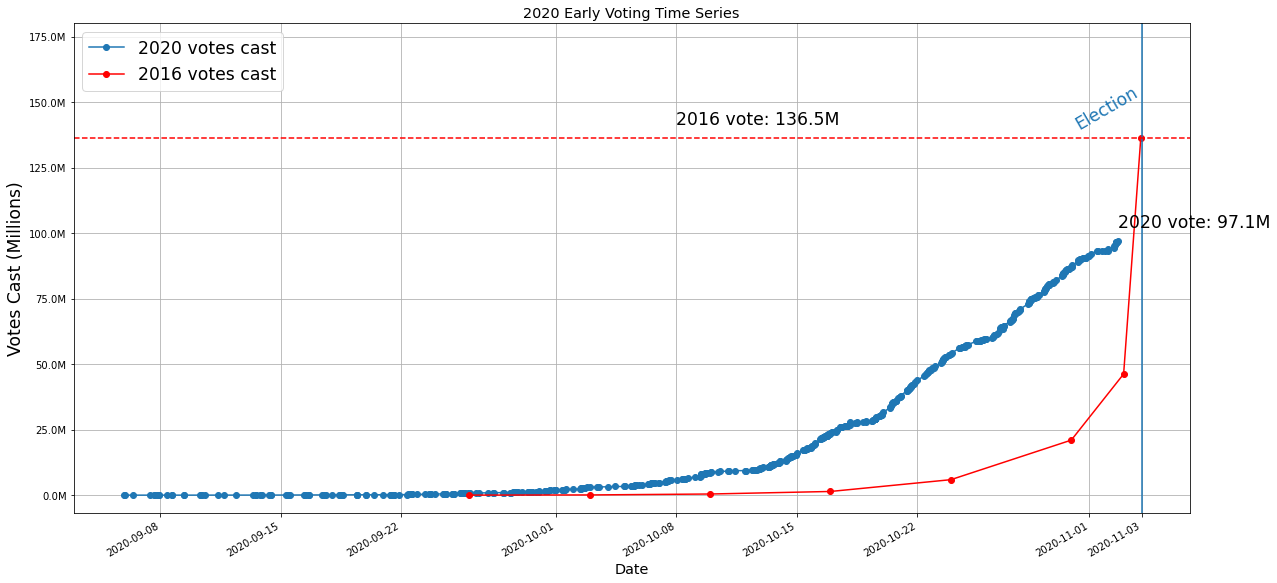

Loading BokehJS ...

In [17]:
update_notebook()